In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import requests
from skimage import io
import math

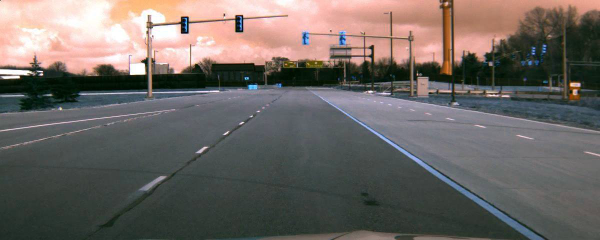

In [ ]:
img_url = "https://raw.githubusercontent.com/kuowenyu/self-driving-car/feature-edits/computer-vision/first%20image.jpg"
img = io.imread(img_url)
width = int(img.shape[1] * 0.5)
height = int(img.shape[0] * 0.5)
dim = (width, height)
cv2_imshow(cv2.resize(img, dim))

In [ ]:
def warp_image(img, src, dst, new_dim):
    BEV_transform = cv2.getPerspectiveTransform(src,dst)
    birdseye_result = cv2.warpPerspective(featureImg, BEV_transform, (new_dim[0], new_dim[1]))
    inverse_BEV_transform = cv2.getPerspectiveTransform(dst, src)
    return birdseye_result, inverse_BEV_transform

In [ ]:
# track lanes and fit them
def track_lanes_initialize(binary_warped):

    global window_search

    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # we need max for each half of the histogram. the example above shows how
    # things could be complicated if didn't split the image in half
    # before taking the top 2 maxes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    # this will throw an error in the height if it doesn't evenly divide the img height
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 1)
    right_fit = np.polyfit(righty, rightx, 1)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty + left_fit[1]
    right_fitx = right_fit[0]*ploty + right_fit[1]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy) + left_fit[1] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy) + left_fit[1] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy) + right_fit[1] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy) + right_fit[1] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 1)
    right_fit = np.polyfit(righty, rightx, 1)

    return left_fit,right_fit

In [ ]:
# A function to get linear polynomial output
def get_val(y,poly_coeff):
    return poly_coeff[0]*y+poly_coeff[1]

In [ ]:
# transform fitted lines back to original perspective
def lane_fill_poly(binary_warped, undist, left_fit, right_fit, inverse_perspective_transform):

    # Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast x and y for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane
    cv2.line(color_warp, (int(left_fitx[240]), int(ploty[240])), (int(left_fitx[-1]), int(ploty[-1])), [0, 255, 0], 15)
    cv2.line(color_warp, (int(right_fitx[240]), int(ploty[240])), (int(right_fitx[-1]), int(ploty[-1])), [0, 255, 0], 15)

    pts = np.array([[int(left_fitx[240]), int(ploty[240])], [int(left_fitx[-1]), int(ploty[-1])], [int(right_fitx[240]), int(ploty[240])], [int(right_fitx[-1]), int(ploty[-1])]], dtype=np.float32)
    outPut = cv2.perspectiveTransform(pts[None, :, :], inverse_perspective_transform)
    # Warp using inverse perspective transform
    newWarp = cv2.warpPerspective(color_warp, inverse_perspective_transform, (binary_warped.shape[1], binary_warped.shape[0]))
    # overlay
    result = cv2.addWeighted(undist, 1, newWarp, 1.0, 0)

    return result, outPut

In [ ]:
def draw_lines(img, lines):
    # If there are no lines to draw, exit.

    left_fit = np.polyfit((lines[0][0][1],lines[0][1][1]), (lines[0][0][0],lines[0][1][0]), 1)
    right_fit = np.polyfit((lines[0][2][1],lines[0][3][1]), (lines[0][2][0],lines[0][3][0]), 1)
    ploty = np.array([480, 200])
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)
    # Loop over all lines and draw them on the blank image.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    cv2.line(line_img, (int(left_fitx[0]), int(ploty[0])), (int(left_fitx[1]), int(ploty[1])), [0,255,255], 2)
    cv2.line(line_img, (int(right_fitx[0]), int(ploty[0])), (int(right_fitx[1]), int(ploty[1])), [255,255,255], 2)

    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)

    # Return the modified image.
    return img, left_fit, right_fit

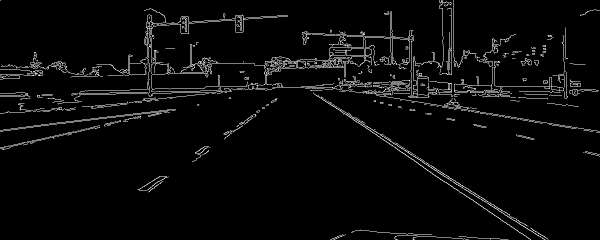

In [ ]:
#### BGR2GRAY, then canny edge detector on the gray image
featureImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
featureImg = cv2.Canny(featureImg,100,200)
cv2_imshow(cv2.resize(featureImg, dim))

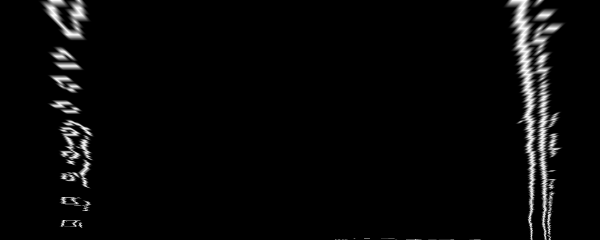

In [ ]:
#### get BEV view of ROI
# define the 4 points from the original image
src = np.float32([[0,480], [1200,480], [665,200], [535,200]])

# define the dimension of the destination image
new_dim = np.float32([1200,480])

# define the 4 points on the destination image
dst = np.float32([[0,480],[1200,480],[1200,0],[0,0]])

birdseye_result, inverse_BEV_transform = warp_image(featureImg, src, dst, new_dim)
cv2_imshow(cv2.resize(birdseye_result, dim))

In [ ]:
left_fit, right_fit = track_lanes_initialize(birdseye_result)
colored_lane, out_put = lane_fill_poly(birdseye_result, img, left_fit, right_fit, inverse_BEV_transform)
result, coef_left, coef_right = draw_lines(img, out_put)
print("Lane Coefficients: %.5f %.2f %.5f %.2f\n" % (coef_left[0], coef_left[1], coef_right[0], coef_right[1]))

Lane Coefficients: -1.39968 828.90 1.56511 336.80



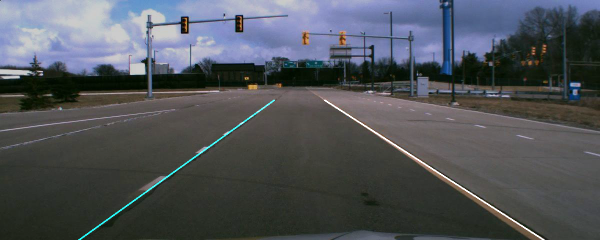

In [ ]:
real_img = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
cv2_imshow(cv2.resize(real_img, dim))